# Phytogeographic image recognizer

CNN Image classificacion model to classify common botanic species in Rio Blanco - Lima - Peru. Trained from a dataset of 3619 own search Google Image photos divided into 17 botanic classes. The application of this code in a mobile app will speed up the preliminary classification in field, especially in students where botanic species recognition is limited.

Original idea from https://youtu.be/dGtDTjYs3xc

### Import dependencies

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Test GPU acceleration

In [2]:
from tensorflow import keras
import sys
print(f"GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(f"GPUs in use?: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow version: {tf.version.VERSION}")
print(f"System version: {sys.version}")
tf.config.list_physical_devices('GPU')

GPUs Available: 1
GPUs in use?: True
Tensorflow version: 2.10.0
System version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparing data of the model

### Constants

In [3]:
Batch_size = 32
Image_size = 288
Channels=3 #RGB
Epochs=250

### Google Drive (for Google Colab)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#%cd '/content/drive/My Drive/Colab Notebooks/Phytogeographic_image_recognizer'

### Import data into tensorflow dataset object

In [6]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Photos",
    shuffle=True,
    seed=0,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 3619 files belonging to 17 classes.


See the classes found

In [7]:
Class_names = Dataset.class_names
print(len(Class_names))
Class_names

17


['Asteraceae_Baccharis',
 'Asteraceae_mutisia',
 'Bromeliaceae_puya',
 'Buddlejaceae_buddleja',
 'Cactaceae_opuntia',
 'Dennstaedtiaceae_pteridium',
 'Fabaceae_Caesalpinioideae',
 'Liliaceae_bomarea',
 'Myrtaceae_eucalyptus',
 'Passifloraceae_passiflora',
 'Pinaceae_pinus',
 'Poaceae_stipa',
 'Polemoniaceae_monnina',
 'Rosaceae_polylepis',
 'Solanaceae_solanum',
 'Tanacetum',
 'Urticaceae_urtica']

Each element in the dataset is a tuple. First element is a batch of 32 elements of images, the second is a batch of 32 elements of class labels.

In [8]:
for Image_batch, Labels_batch in Dataset.take(1):
    print(Image_batch.shape)
    print(Labels_batch.numpy())

(32, 288, 288, 3)
[ 8 13  9 12  0  9 14  2 16  3  0  3 16  2  2  1 10  2 12 13  2 16  1  5
 14  0  2  9  5  8  9 16]


### Visualize some images of the dataset

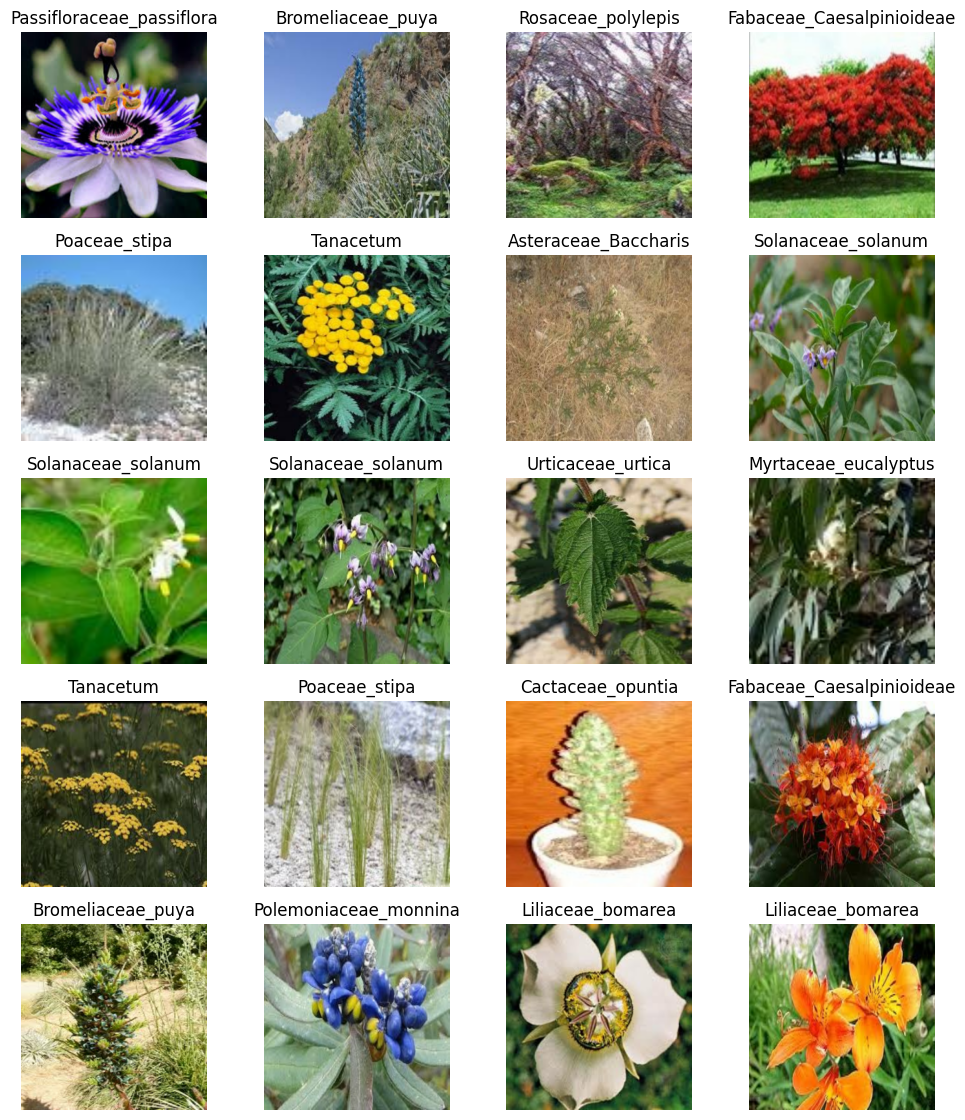

In [9]:
plt.figure(figsize=(12, 14))
for Image_batch, Labels_batch in Dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(Image_batch[i].numpy().astype("uint8"))
        plt.title(Class_names[Labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset will be divided in 3 subsets (Andrew Ng recommandation):
1. Training: Dataset to be used while training (60%)
2. Validation: Dataset to be tested against while training (20%)
3. Test: Dataset to be tested against after we trained a model (20%)

In [10]:
print(f'Dataset length: {len(Dataset)}')

Dataset length: 114


### Function to get partitions of the dataset 

Split training dataset in 60% to reduce overfitting

In [11]:
def Get_dataset_partitions_tf(Ds, Train_split=0.6, Val_split=0.20, Test_split=0.20, Shuffle=True, Shuffle_size=10000):
    assert (Train_split + Test_split + Val_split) == 1
    
    Ds_size = len(Ds) #Lenght of the Dataset
    
    if Shuffle:
        Ds = Ds.shuffle(Shuffle_size, seed=0) #Suffle
    
    Train_size = int(Train_split * Ds_size) #Size of 0.6 of dataset rounded (or Train_split defined)
    Val_size = int(Val_split * Ds_size) #Size of 0.2 of dataset rounded (or Test_split defined)
    
    Train_ds = Ds.take(Train_size) #Take 0.6 of dataset (or Train_split defined)
    Val_ds = Ds.skip(Train_size).take(Val_size) #Take 0.2 of dataset after 0.6 taked (or Val_split defined)
    Test_ds = Ds.skip(Train_size).skip(Val_size) #Take 0.2 of dataset after 0.8 taked (or Test_split defined)
    
    return Train_ds, Val_ds, Test_ds

In [12]:
Train_ds, Val_ds, Test_ds = Get_dataset_partitions_tf(Dataset)

In [13]:
print(f'Training Dataset length: {len(Train_ds)}')
print(f'Validation Dataset length: {len(Val_ds)}')
print(f'Test Dataset length: {len(Test_ds)}')

Training Dataset length: 68
Validation Dataset length: 22
Test Dataset length: 24


### Cache, Shuffle, and Prefetch the Dataset

In [14]:
Train_ds = Train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_ds = Val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_ds = Test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model

### Creating a Layer for Resizing and Normalization

In [15]:
Resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_size, Image_size),
  layers.Rescaling(1./255) #Normalize, 
])

### Data Augmentation
Augmenting the data to boosts the accuracy of the model.

In [16]:
Data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.001),
  layers.RandomContrast(0.001),
  layers.RandomZoom(height_factor=0.001,width_factor=0.001)
])

#### Applying Data Augmentation to Train Dataset

In [17]:
Train_ds = Train_ds.map(
    lambda x, y: (Data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
CNN coupled with a Softmax activation in the output layer. CNN is popular for image classification. Initials layers for resizing, normalization and Data Augmentation.

In [18]:
Input_shape = (Batch_size, Image_size, Image_size, Channels)
N_classes = len(Class_names) #Number of classes

Model = models.Sequential([
    Resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=Input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4), #Reduce overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(N_classes, activation='softmax'),
])

Model.build(input_shape=Input_shape)

In [19]:
Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 288, 288, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 286, 286, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 143, 143, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 141, 141, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 70, 70, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 68, 68, 64)         

### Compiling the Model

In [20]:
Model.compile(
    optimizer = 'adam',
    loss = "SparseCategoricalCrossentropy",
    metrics = ['accuracy']
)

Make a checkpoint to use the better run by accuracy

In [21]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Checkpoint_model.hdf5',
    verbose = 1,
    monitor = 'accuracy',
    save_best_only = True
)

In [22]:
#%%capture --no-display
#Hide too long output. Comment to watch the status of the model fit.

History = Model.fit(
    Train_ds,
    batch_size=Batch_size,
    validation_data=Val_ds,
    callbacks=[Checkpoint],
    verbose=1,
    epochs=Epochs,
)

Epoch 1/250
68/68 [==============================] - ETA: 0s - loss: 2.8223 - accuracy: 0.0657
Epoch 1: accuracy improved from -inf to 0.06572, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 19s 204ms/step - loss: 2.8223 - accuracy: 0.0657 - val_loss: 2.7983 - val_accuracy: 0.0622
Epoch 2/250
68/68 [==============================] - ETA: 0s - loss: 2.7822 - accuracy: 0.0790
Epoch 2: accuracy improved from 0.06572 to 0.07904, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 12s 179ms/step - loss: 2.7822 - accuracy: 0.0790 - val_loss: 2.7193 - val_accuracy: 0.0785
Epoch 3/250
68/68 [==============================] - ETA: 0s - loss: 2.6975 - accuracy: 0.1016
Epoch 3: accuracy improved from 0.07904 to 0.10156, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 12s 180ms/step - loss: 2.6975 - accuracy: 0.1016 - val_loss: 2.6620 - val_accuracy: 0.0904
Epoch 4/250
68/68 [==============================] -

68/68 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.5285
Epoch 27: accuracy improved from 0.52068 to 0.52849, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 11s 167ms/step - loss: 1.4055 - accuracy: 0.5285 - val_loss: 1.6924 - val_accuracy: 0.5185
Epoch 28/250
68/68 [==============================] - ETA: 0s - loss: 1.3291 - accuracy: 0.5551
Epoch 28: accuracy improved from 0.52849 to 0.55515, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 12s 170ms/step - loss: 1.3291 - accuracy: 0.5551 - val_loss: 1.6658 - val_accuracy: 0.5467
Epoch 29/250
68/68 [==============================] - ETA: 0s - loss: 1.3472 - accuracy: 0.5524
Epoch 29: accuracy did not improve from 0.55515
68/68 [==============================] - 11s 168ms/step - loss: 1.3472 - accuracy: 0.5524 - val_loss: 1.5600 - val_accuracy: 0.5615
Epoch 30/250
68/68 [==============================] - ETA: 0s - loss: 1.2675 - accuracy: 0.5740
Epo

Epoch 54/250
68/68 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8359
Epoch 54: accuracy improved from 0.81342 to 0.83594, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 11s 169ms/step - loss: 0.4930 - accuracy: 0.8359 - val_loss: 1.7210 - val_accuracy: 0.7126
Epoch 55/250
68/68 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.8387
Epoch 55: accuracy improved from 0.83594 to 0.83869, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 11s 168ms/step - loss: 0.4914 - accuracy: 0.8387 - val_loss: 1.7504 - val_accuracy: 0.7096
Epoch 56/250
68/68 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8231
Epoch 56: accuracy did not improve from 0.83869
68/68 [==============================] - 11s 167ms/step - loss: 0.5399 - accuracy: 0.8231 - val_loss: 1.8208 - val_accuracy: 0.6993
Epoch 57/250
68/68 [==============================] - ETA: 0s - loss: 0.5581 - accurac

68/68 [==============================] - 11s 167ms/step - loss: 0.2683 - accuracy: 0.9223 - val_loss: 2.1084 - val_accuracy: 0.7230
Epoch 82/250
68/68 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9311
Epoch 82: accuracy improved from 0.92233 to 0.93107, saving model to Checkpoint_model.hdf5
68/68 [==============================] - 11s 168ms/step - loss: 0.2175 - accuracy: 0.9311 - val_loss: 2.0429 - val_accuracy: 0.7437
Epoch 83/250
68/68 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.9182
Epoch 83: accuracy did not improve from 0.93107
68/68 [==============================] - 11s 168ms/step - loss: 0.2689 - accuracy: 0.9182 - val_loss: 1.9983 - val_accuracy: 0.7319
Epoch 84/250
68/68 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9095
Epoch 84: accuracy did not improve from 0.93107
68/68 [==============================] - 11s 167ms/step - loss: 0.2834 - accuracy: 0.9095 - val_loss: 1.9302 - val_accuracy: 0.72

68/68 [==============================] - 11s 168ms/step - loss: 0.1422 - accuracy: 0.9573 - val_loss: 2.3024 - val_accuracy: 0.7333
Epoch 111/250
68/68 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9462
Epoch 111: accuracy did not improve from 0.95726
68/68 [==============================] - 11s 168ms/step - loss: 0.1653 - accuracy: 0.9462 - val_loss: 2.4550 - val_accuracy: 0.7274
Epoch 112/250
68/68 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9301
Epoch 112: accuracy did not improve from 0.95726
68/68 [==============================] - 11s 168ms/step - loss: 0.2398 - accuracy: 0.9301 - val_loss: 2.1848 - val_accuracy: 0.7304
Epoch 113/250
68/68 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9343
Epoch 113: accuracy did not improve from 0.95726
68/68 [==============================] - 11s 168ms/step - loss: 0.2083 - accuracy: 0.9343 - val_loss: 2.2353 - val_accuracy: 0.7274
Epoch 114/250
68/68 [=============

Epoch 140/250
68/68 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9527
Epoch 140: accuracy did not improve from 0.96186
68/68 [==============================] - 11s 167ms/step - loss: 0.1536 - accuracy: 0.9527 - val_loss: 2.4285 - val_accuracy: 0.7319
Epoch 141/250
68/68 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9412
Epoch 141: accuracy did not improve from 0.96186
68/68 [==============================] - 11s 166ms/step - loss: 0.2098 - accuracy: 0.9412 - val_loss: 2.4282 - val_accuracy: 0.7185
Epoch 142/250
68/68 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9426
Epoch 142: accuracy did not improve from 0.96186
68/68 [==============================] - 11s 167ms/step - loss: 0.2010 - accuracy: 0.9426 - val_loss: 2.2868 - val_accuracy: 0.7348
Epoch 143/250
68/68 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9444
Epoch 143: accuracy did not improve from 0.96186
68/68 [=============

68/68 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9545
Epoch 198: accuracy did not improve from 0.97197
68/68 [==============================] - 11s 168ms/step - loss: 0.1651 - accuracy: 0.9545 - val_loss: 2.4974 - val_accuracy: 0.7333
Epoch 199/250
68/68 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9366
Epoch 199: accuracy did not improve from 0.97197
68/68 [==============================] - 11s 168ms/step - loss: 0.1977 - accuracy: 0.9366 - val_loss: 2.4236 - val_accuracy: 0.7333
Epoch 200/250
68/68 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9582
Epoch 200: accuracy did not improve from 0.97197
68/68 [==============================] - 11s 166ms/step - loss: 0.1390 - accuracy: 0.9582 - val_loss: 2.4289 - val_accuracy: 0.7230
Epoch 201/250
68/68 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9683
Epoch 201: accuracy did not improve from 0.97197
68/68 [===========================

**Load the best model (by accuracy)**

In [23]:
Model_checkpoint_best = Model
Model_checkpoint_best.load_weights('./Checkpoint_model.hdf5')

In [24]:
Scores = Model_checkpoint_best.evaluate(Test_ds)

24/24 [==============================] - 2s 20ms/step - loss: 2.2376 - accuracy: 0.7669


Scores is a list containing loss and accuracy value respectively. 79.17% is a decent accuracy.

In [25]:
Scores

[2.2376155853271484, 0.7669270634651184]

### Plotting the Accuracy and Loss Curves

In [26]:
History

In [27]:
History.params

{'verbose': 1, 'epochs': 250, 'steps': 68}

In [28]:
History.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**'loss', 'accuracy', 'val loss' and 'val_accuracy' are a python list containing values at the end of each epoch**

In [29]:
print(f"Type of History.history['loss']: {type(History.history['loss'])}")

Type of History.history['loss']: <class 'list'>


In [30]:
print(f"Length of History.history['loss']: {len(History.history['loss'])}")

Length of History.history['loss']: 250


In [31]:
History.history['loss'][:5] #Loss for first 5 epochs

[2.822291851043701,
 2.782162666320801,
 2.6974992752075195,
 2.6426918506622314,
 2.6267077922821045]

In [32]:
Acc = History.history['accuracy']
Val_acc = History.history['val_accuracy']

Loss = History.history['loss']
Val_loss = History.history['val_loss']

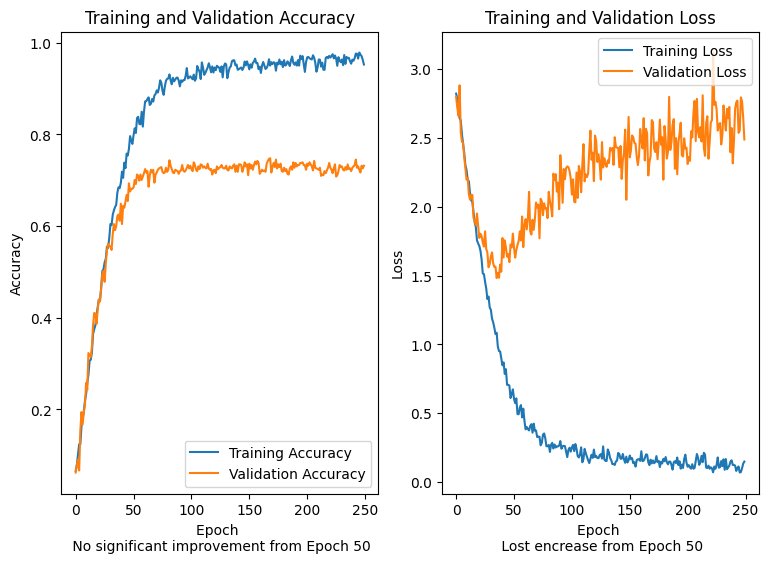

In [33]:
plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), Acc, label='Training Accuracy')
plt.plot(range(Epochs), Val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch \n No significant improvement from Epoch 50')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), Loss, label='Training Loss')
plt.plot(range(Epochs), Val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch \n Lost encrease from Epoch 50')

plt.show()

### Run prediction on a sample image

First image to predict
Actual label: Dennstaedtiaceae_pteridium
1/1 [==============================] - 0s 109ms/step
predicted label: Dennstaedtiaceae_pteridium


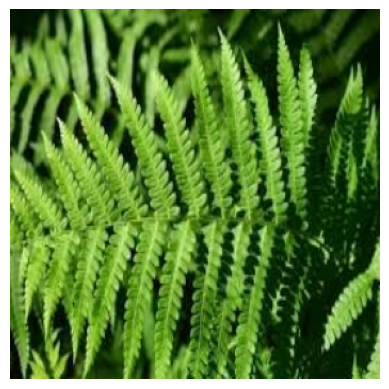

In [34]:
for Images_batch, Labels_batch in Test_ds.take(1):
    First_image = Images_batch[0].numpy().astype('uint8')
    First_label = Labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(First_image)
    plt.axis("off")
    print("Actual label:",Class_names[First_label])
    
    Batch_prediction = Model_checkpoint_best.predict(Images_batch)
    print("predicted label:",Class_names[np.argmax(Batch_prediction[0])])

### Write a function for inference

Function to randomly select 9 images and show his actual and predicte classes and confidence

In [35]:
def Predict(Model, Img):
    Img_array = tf.keras.preprocessing.image.img_to_array(Images[i].numpy())
    Img_array = tf.expand_dims(Img_array, 0)

    Predictions = Model.predict(Img_array)

    Predicted_class = Class_names[np.argmax(Predictions[0])]
    Confidence = round(100 * (np.max(Predictions[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 16ms/step


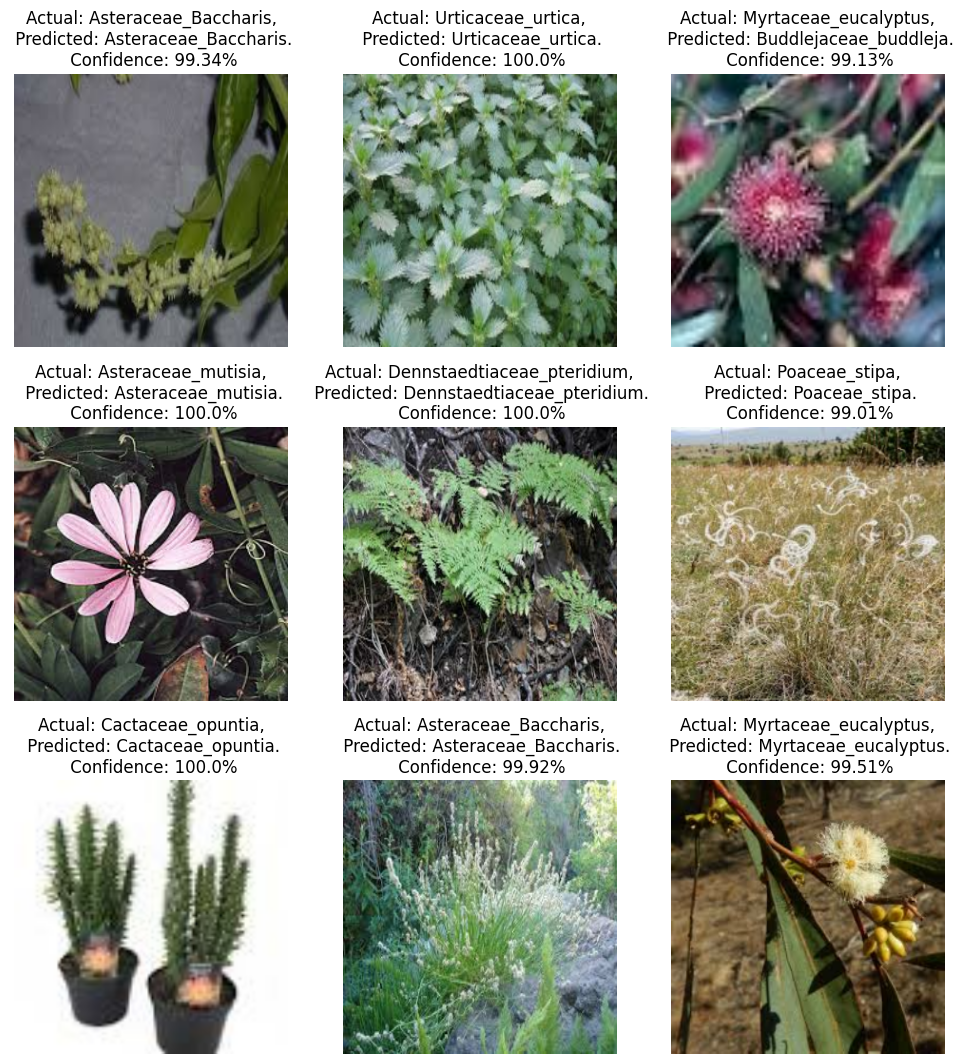

In [41]:
plt.figure(figsize=(12, 13))
for Images, Labels in Test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Images[i].numpy().astype("uint8"))
        
        Predicted_class, Confidence = Predict(Model_checkpoint_best, Images[i].numpy())
        Actual_class = Class_names[Labels[i]]
        
        plt.title(f"Actual: {Actual_class},\n Predicted: {Predicted_class}.\n Confidence: {Confidence}%")
        plt.axis("off")

### Saving the Model

In a folder

In [37]:
import os

Dir = "./Saved_models"
if os.path.exists(Dir):
    Model_version=max([int(i) for i in os.listdir(Dir) + [0]])+1
    Model_checkpoint_best.save(f"./Saved_models/{Model_version}")
else:
    os.mkdir(Dir)
    Model_version=max([int(i) for i in os.listdir(Dir) + [0]])+1

INFO:tensorflow:Assets written to: ./Saved_models/1\assets


INFO:tensorflow:Assets written to: ./Saved_models/1\assets


In a *.h5 file

In [38]:
Model_checkpoint_best.save("./Phytogeographic_classification_model.h5")

## Idea for a continuation of the project

The next step that is outside the objectives of the project is to develop an app that communicates with a server where the model will be hosted.
The app would send a photo to the server where you want to know the name of the botanical species and it will process it in the model, returning its name.
The *.h5 file created in the previous step is the already trained model and its execution is much lighter than training the model, but it is somewhat heavy to run locally.